#Introducción

Este notebook entrena a un agente para navegar por un laberinto y llegar al destino deseado. Utiliza el entorno fourRoom-v0 del Gym-MiniGrid como laberinto. El agente se entrena utilizando el algoritmo de gradiente de política básico (REINFORCE) del aprendizaje por refuerzo.

In [ ]:
!pip install gym
!pip install gym-minigrid

In [ ]:
import gym, gym_minigrid

import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import base64
import glob
import io
import time
import copy
#import utils

import torch
import torch.nn as nn
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical

In [ ]:
SEED = 2123

# Definición de componentes de aprendizaje por refuerzo.

Se espera que cualquier implementación de refuerzo tenga cuatro componentes:
* Un entorno, es decir, donde reside el agente, tiene espacio de acción, es decir, qué acciones son posibles en este entorno y observaciones, es decir, el estado del medio ambiente en un momento dado (posición de las paredes, agente, comida, etc.)
* El modelo que actúa como la mente del agente, es decir, toma decisiones sobre qué acciones debe realizar un agente en el entorno.
* El rolloutbuffer: la estructura de datos que recopila y almacena datos de entrenamiento.
* La política: algoritmos para actualizar los parámetros del modelo para que el modelo tome mejores decisiones.

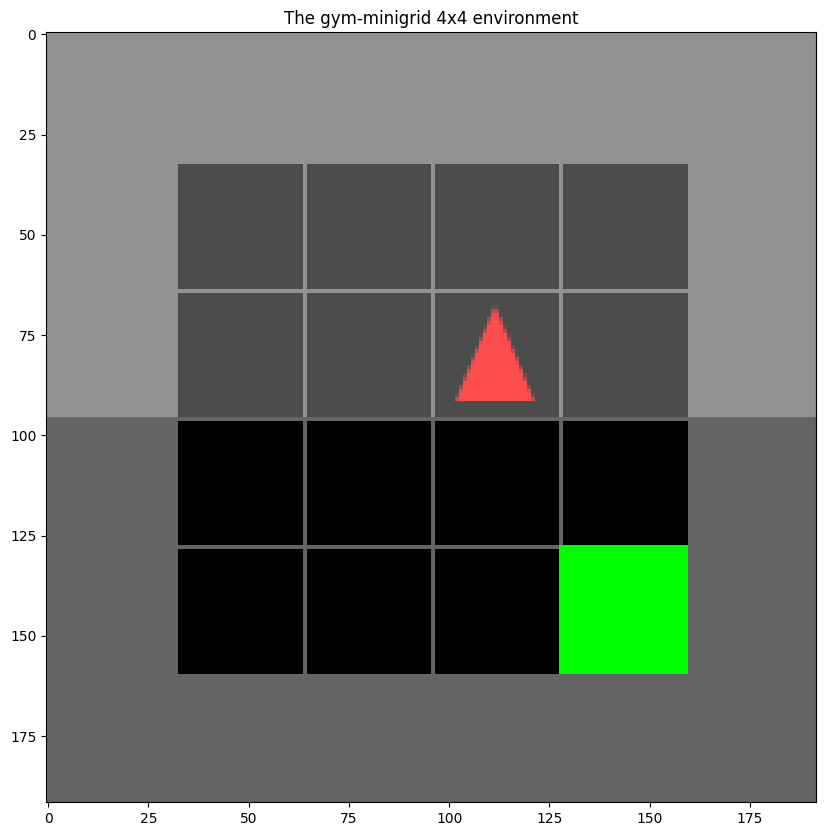

In [ ]:
def display_environment() -> None:
    '''
    Converts an environment to an image and displays it on the notebook.
    '''
    # Set the render mode when creating the environment
    env = gym.make('MiniGrid-Empty-Random-6x6-v0', render_mode="rgb_array")
    env.reset()
    # Call render without any arguments
    img = env.render()
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray')
    plt.title("The gym-minigrid 4x4 environment")
    plt.show()

# Call the function without any arguments
display_environment()

No es eficiente trabajar con un entorno 3D, por lo que aplanamos el entorno a un vector 1D. Para hacer esto utilizamos el FlatObsWrapper definido a continuación.

In [ ]:
class FlatObsWrapper(gym.core.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            #dtype='uint8'
            dtype = float
        )
        self.unwrapped.max_steps = 100

    def observation(self, obs):
        '''
        This method is called in the reset() and step() functions to get the observation.
        env.reset() returns the environment with the goal, walls and empty spaces in place but no agent in it.
        This function places the agent into the environment and flattens the env.
        '''
        env = self.unwrapped
        full_grid = env.grid.encode()

        #places the agent in the grid
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            gym_minigrid.minigrid.OBJECT_TO_IDX['agent'],
            gym_minigrid.minigrid.COLOR_TO_IDX['red'],
            env.agent_dir
        ])

        #remove outer walls of the environment (for efficiency)
        full_grid = full_grid[1:-1, 1:-1]

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def render(self, *args, **kwargs):
        """
        This removes the default visualization of the partially observable field of view.
        """
        kwargs['highlight'] = False
        return self.unwrapped.render(*args, **kwargs)

In [ ]:
env = FlatObsWrapper(env)

**Rollout buffer:** El aprendizaje reforzado funciona recopilando primero datos que luego serán utilizados por el usuario para capacitar al agente. El búfer de implementación es la estructura de datos para almacenar dichos datos. Una instancia en los datos recopilados consiste en una observación, una acción realizada, la recompensa obtenida
y si la acción resultó en un estado terminal.

In [ ]:
class RolloutBuffer():
    def __init__(self, rollout_size, obs_size):
        '''
        Initializes the size i.e. number of instances and of the rolloutbuffer
        '''
        self.rollout_size = rollout_size
        self.obs_size = obs_size
        self.reset()

    def insert(self, step, done, action, log_prob, reward, obs):
        '''
        Inserts an instance i.e. a data example to the rolloutbuffer.
        '''
        self.done[step].copy_(done)
        self.actions[step].copy_(action)
        self.log_probs[step].copy_(log_prob)
        self.rewards[step].copy_(reward)
        self.obs[step].copy_(obs)

    def reset(self):
        '''
        Clears the rollout buffer of any existing data.
        '''
        self.done = torch.zeros(self.rollout_size, 1)
        self.returns = torch.zeros(self.rollout_size + 1, 1, requires_grad=False)
        # Assuming Discrete Action Space
        self.actions = torch.zeros(self.rollout_size, 1, dtype=torch.int64)
        self.log_probs = torch.zeros(self.rollout_size, 1)
        self.rewards = torch.zeros(self.rollout_size, 1)
        self.obs = torch.zeros(self.rollout_size, self.obs_size)

    def compute_returns(self, gamma):
        '''
        Computes the expected return of each instance.
        Expected return computation for an instance uses a group of intances before the terminal state is used.
        '''
        self.last_done = (self.done == 1).nonzero().max()
        self.returns[self.last_done + 1] = 0.

        # Accumulate discounted returns
        for step in reversed(range(self.last_done + 1)):
            self.returns[step] = self.returns[step + 1] * \
                gamma * (1 - self.done[step]) + self.rewards[step]


    def batch_sampler(self, batch_size, get_old_log_probs=False):
        '''
        Returns a small random amount of instances from the rolloutbuffer.
        '''
        sampler = BatchSampler(SubsetRandomSampler(range(self.last_done)), batch_size, drop_last=True)

        for indices in sampler:
            if get_old_log_probs:
                yield self.actions[indices], self.returns[indices], self.obs[indices], self.log_probs[indices]
            else:
                yield self.actions[indices], self.returns[indices], self.obs[indices]

**El actor/agente/modelo:** Es la red neuronal que ordena qué acción debe realizar un agente dado el estado actual del entorno.


In [ ]:
class ActorNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super().__init__()
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(num_inputs, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_actions)
        )

    def forward(self, state):
        x = self.fc(state)
        return x

**La Política:** Equivale a un optimizador en el aprendizaje supervisado regular a través de redes neuronales. Le preocupa cómo actualizar los parámetros del modelo para que el modelo pueda hacer mejores recomendaciones de acción.


In [ ]:
class Policy():
    def __init__(self, num_inputs, num_actions, hidden_dim, learning_rate, batch_size, policy_epochs, entropy_coef):
        self.actor = ActorNetwork(num_inputs, num_actions, hidden_dim)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
        self.batch_size = batch_size
        self.policy_epochs = policy_epochs
        self.entropy_coef = entropy_coef

    def act(self, state):
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action, log_prob

    def evaluate_actions(self, state, action):
        logits = self.actor(state)
        dist = Categorical(logits=logits)
        log_prob = dist.log_prob(action.squeeze(-1)).view(-1, 1)
        entropy = dist.entropy().view(-1, 1)
        return log_prob, entropy

    def update(self, rollouts):
        for epoch in range(self.policy_epochs):
            data = rollouts.batch_sampler(self.batch_size)

            for sample in data:
                actions_batch, returns_batch, obs_batch = sample

                log_probs_batch, entropy_batch = self.evaluate_actions(obs_batch, actions_batch)

                policy_loss = -(log_probs_batch * returns_batch).mean()
                entropy_loss = -entropy_batch.mean()

                loss = policy_loss + self.entropy_coef * entropy_loss

                self.optimizer.zero_grad()
                loss.backward(retain_graph=False)
                self.optimizer.step()

    @property
    def num_params(self):
        return sum(p.numel() for p in self.actor.parameters())

In [ ]:
hidden_dim = 32         # dimension of the hidden state in actor network
learning_rate = 1e-3     # learning rate of policy update
batch_size = 1024        # batch size for policy update
policy_epochs = 4        # number of epochs per policy update
entropy_coef = 0.001     # hyperparameter to vary the contribution of entropy loss

rollout_size = 2050      # number of collected rollout steps per policy update
num_updates = 50         # number of training policy iterations
discount = 0.99          # discount factor
plotting_iters = 10      # interval for logging graphs and policy rollouts


obs_size = env.observation_space.shape[0]
num_actions = env.action_space.n

rollouts = RolloutBuffer(rollout_size, obs_size)
policy = Policy(obs_size, num_actions,  hidden_dim, learning_rate, batch_size, policy_epochs, entropy_coef)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(env, rollouts, policy, num_updates, discount, plotting_iters):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    rollout_time, update_time = utils.AverageMeter(), utils.AverageMeter()  # Loggers
    rewards, success_rate = [], []

    print("Training model with {} parameters...".format(policy.num_params))

    # Training Loop
    for j in range(num_updates):
        ## Initialization
        avg_eps_reward, avg_success_rate = utils.AverageMeter(), utils.AverageMeter()
        done = False

        env.seed(SEED)
        prev_obs = env.reset()
        prev_obs = torch.tensor(prev_obs, dtype=torch.float32)
        eps_reward = 0.
        start_time = time.time()

        ## Collect rollouts
        for step in range(rollouts.rollout_size):
            if done:
                # Store episode statistics
                avg_eps_reward.update(eps_reward)
                if 'success' in info:
                    avg_success_rate.update(int(info['success']))

                # Reset Environment
                obs = env.reset()
                obs = torch.tensor(obs, dtype=torch.float32)
                eps_reward = 0.
            else:
                obs = prev_obs

            action, log_prob = policy.act(obs)

            obs, reward, done, info = env.step(action)

            rollouts.insert(step, torch.tensor(done, dtype=torch.float32), action, log_prob, torch.tensor(reward, dtype=torch.float32), prev_obs)

            prev_obs = torch.tensor(obs, dtype=torch.float32)
            eps_reward += reward

        # Use the rollout buffer's function to compute the returns for all stored rollout steps.
        rollouts.compute_returns(discount)

        rollout_done_time = time.time()


        # Call the policy's update function using the collected rollouts
        policy.update(rollouts)

        update_done_time = time.time()
        rollouts.reset()

        ## log metrics
        rewards.append(avg_eps_reward.avg)

        if avg_success_rate.count > 0: success_rate.append(avg_success_rate.avg)

        rollout_time.update(rollout_done_time - start_time)
        update_time.update(update_done_time - rollout_done_time)
        print('it {}: avgR: {:.3f} -- rollout_time: {:.3f}sec -- update_time: {:.3f}sec'.format(j, avg_eps_reward.avg, rollout_time.avg, update_time.avg))

        if j % plotting_iters == 0 and j != 0:
           utils.plot_learning_curve(rewards, success_rate, num_updates)
           #log_policy_rollout(policy, params.env_name, pytorch_policy=True)

    clear_output()   # this removes all training outputs to keep the notebook clean, DON'T REMOVE THIS LINE!
    return rewards, success_rate #average rewards in each rollout

In [ ]:
avg_rollout_rewards, success_rate = train(env, rollouts, policy, num_updates, discount, plotting_iters)

NameError: name 'utils' is not defined

**Evaluación:** Reproduzca un solo episodio en un entorno siguiendo la política dada e informe los resultados.  gym.wrappers.Monitor envuelve un entorno de modo que registra todas las acciones que tienen lugar en el entorno antes de que se alcance un estado terminal. Una vez que se alcanza el estado terminal, la grabación se almacena. Si se inicia un nuevo eposido, el archivo grabado se sobrescribe